In [1]:
#! /usr/bin/env python3
import importlib
import inspect
import pprint
#
from Pegasus.api import *
pegasus_graphviz = importlib.import_module("Pegasus.cli.pegasus-graphviz")

import graphviz as graphviz
import pygraphviz as pgv
from IPython.display import Image
import yaml as yaml
import pydot as pydot

import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import ast
from PIL import ImageColor

In [2]:
# --- Raw input file -----------------------------------------------------------------

fa = File("f.a").add_metadata(creator="ryan")

# --- Workflow -----------------------------------------------------------------
'''
                        [f.b1] - (findrange) - [f.c1]
                        /                             \
[f.a] - (preprocess)                               (analyze) - [f.d]
                        \                             /
                        [f.b2] - (findrange) - [f.c2]

'''
wf = Workflow("diamond")

wf.add_shell_hook(EventType.START, "/pegasus/libexec/notification/email -t notify@example.com")
wf.add_shell_hook(EventType.END, "/pegasus/libexec/notification/email -t notify@example.com")

fb1 = File("f.b1")
fb2 = File("f.b2")
job_preprocess = Job("preprocess")\
                        .add_args("-a", "preprocess", "-T", "3", "-i", fa, "-o", fb1, fb2)\
                        .add_inputs(fa)\
                        .add_outputs(fb1, fb2)\
                        .add_metadata(time=60)\
                        .add_shell_hook(EventType.START, "/pegasus/libexec/notification/email -t notify@example.com")\
                        .add_shell_hook(EventType.END, "/pegasus/libexec/notification/email -t notify@example.com")


fc1 = File("f.c1")
job_findrange_1 = Job("findrange")\
                        .add_args("-a", "findrange", "-T", "3", "-i", fb1, "-o", fc1)\
                        .add_inputs(fb1)\
                        .add_outputs(fc1)\
                        .add_metadata(time=60)\
                        .add_shell_hook(EventType.START, "/pegasus/libexec/notification/email -t notify@example.com")\
                        .add_shell_hook(EventType.END, "/pegasus/libexec/notification/email -t notify@example.com")

fc2 = File("f.c2")
job_findrange_2 = Job("findrange")\
                        .add_args("-a", "findrange", "-T", "3", "-i", fb2, "-o", fc2)\
                        .add_inputs(fb2)\
                        .add_outputs(fc2)\
                        .add_metadata(time=60)\
                        .add_shell_hook(EventType.START, "/pegasus/libexec/notification/email -t notify@example.com")\
                        .add_shell_hook(EventType.END, "/pegasus/libexec/notification/email -t notify@example.com")

fd = File("f.d").add_metadata(final_output="true")
job_analyze = Job("analyze")\
               .add_args("-a", "analyze", "-T", "3", "-i", fc1, fc2, "-o", fd)\
               .add_inputs(fc1, fc2)\
               .add_outputs(fd)\
               .add_metadata(time=60)\
               .add_shell_hook(EventType.START, "/pegasus/libexec/notification/email -t notify@example.com")\
               .add_shell_hook(EventType.END, "/pegasus/libexec/notification/email -t notify@example.com")

wf.add_jobs(job_preprocess, job_findrange_1, job_findrange_2, job_analyze)
wf.write()
workflow_file = wf.path

In [3]:
# display methods of something
# pprint.pprint(dir(wf))

# display args of function
# inspect.getfullargspec(wf.add_jobs)

In [4]:
dot_file = "workflow.dot"
# invoke emit_dot on the workflow : show file input/outputs
dag = pegasus_graphviz.parse_yamlfile(workflow_file, include_files=True)
# remove redundant dependency links
# dag = pegasus_graphviz.transitivereduction(dag)

pegasus_graphviz.emit_dot(dag, label_type='xform-id', outfile=str(dot_file))

<Pegasus.cli.pegasus-graphviz.emit_dot at 0x7fdf35feeeb8>

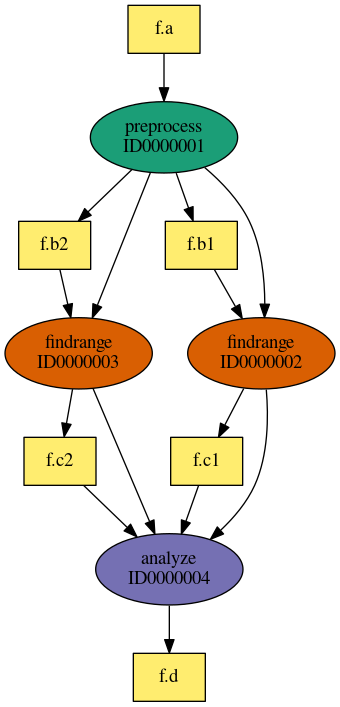

In [5]:
s = graphviz.Source.from_file(dot_file)
image_file = graphviz.render(filepath=dot_file, engine='dot', format='png')
Image(filename=image_file) 

In [6]:
with open(workflow_file) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    workflow_yaml = yaml.load(file, Loader=yaml.FullLoader)
    
#pprint.pprint(workflow_yaml)
    
for key, value in workflow_yaml['jobDependencies']:
    print(key, value)
    

id children
id children
id children


In [7]:
dir(nx);

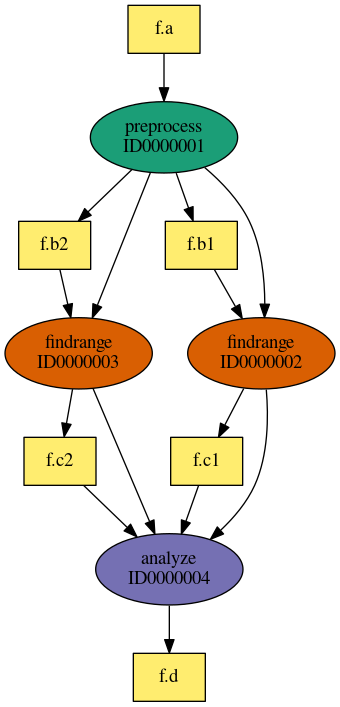

In [8]:
(pydot_graph,) = pydot.graph_from_dot_file(dot_file)
# print(pydot_graph)
pydot_graph.write_png(image_file)
pprint.pprint(pydot_graph)
Image(filename=image_file) 

{'ID0000001': 'preprocess\nID0000001', 'ID0000002': 'findrange\nID0000002', 'ID0000003': 'findrange\nID0000003', 'ID0000004': 'analyze\nID0000004', 'f.a': 'f.a', 'f.b1': 'f.b1', 'f.b2': 'f.b2', 'f.c1': 'f.c1', 'f.c2': 'f.c2', 'f.d': 'f.d'} 
 [(0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0)] 
 [(0.10546875, 0.6171875, 0.46484375), (0.84765625, 0.37109375, 0.0078125), (0.84765625, 0.37109375, 0.0078125), (0.45703125, 0.4375, 0.69921875), (0.99609375, 0.92578125, 0.43359375), (0.99609375, 0.92578125, 0.43359375), (0.99609375, 0.92578125, 0.43359375), (0.99609375, 0.92578125, 0.43359375), (0.99609375, 0.92578125, 0.43359375), (0.99609375, 0.92578125, 0.43359375)] 
 ['o', 'o', 'o', 'o', '^', '^', '^', '^', '^', '^']


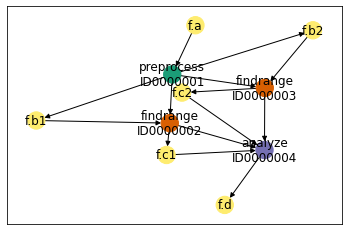

In [9]:
dot_graph = nx.DiGraph((nx.drawing.nx_pydot.read_dot(dot_file)))
pprint.pprint(dot_graph)

shape_dict = { 'ellipse' : 'o', 'rect' : '^'}

# extract node info from graph as one dictionary per attribute
labels = {}
colors = []
fill   = []
shape  = []
for n in dot_graph.nodes(data=True):
    labels[n[0]] = ast.literal_eval(n[1]['label'])
    col  = tuple(N/256.0 for N in ImageColor.getrgb(ast.literal_eval(n[1]['color'])))
    fcol = tuple(N/256.0 for N in ImageColor.getrgb(ast.literal_eval(n[1]['fillcolor'])))
    colors.append(col)
    fill.append(fcol)
    shape.append(shape_dict[n[1]['shape']]) 
    
# print(inspect.getfullargspec(nx.draw_networkx))
print(labels, "\n", colors, "\n", fill, "\n", shape)
shapes = 'so^>v<dph8'
nx.draw_networkx(dot_graph, with_labels=True, labels=labels, node_color=fill, node_shape='o')
#plt.show()

digraph dag {
	graph [name=dag,
		ratio=fill
	];
	node [color="#444444",
		fillcolor="#ffed6f",
		style=filled
	];
	edge [arrowhead=normal,
		arrowsize=1.0
	];
	ID0000001	 [color="#000000",
		fillcolor="#1b9e77",
		label="preprocess\nID0000001",
		shape=ellipse];
	"f.b2"	 [color="#000000",
		label="f.b2",
		shape=rect];
	ID0000001 -> "f.b2" [key=0,
	color="#000000"];
"f.b1" [color="#000000",
	label="f.b1",
	shape=rect];
ID0000001 -> "f.b1" [key=0,
color="#000000"];
ID0000003 [color="#000000",
fillcolor="#d95f02",
label="findrange\nID0000003",
shape=ellipse];
ID0000001 -> ID0000003 [key=0,
color="#000000"];
ID0000002 [color="#000000",
fillcolor="#d95f02",
label="findrange\nID0000002",
shape=ellipse];
ID0000001 -> ID0000002 [key=0,
color="#000000"];
"f.b2" -> ID0000003 [key=0,
color="#000000"];
"f.b1" -> ID0000002 [key=0,
color="#000000"];
"f.c2" [color="#000000",
label="f.c2",
shape=rect];
ID0000003 -> "f.c2" [key=0,
color="#000000"];
ID0000004 [color="#000000",
fillcolor="#7570b3",
lab

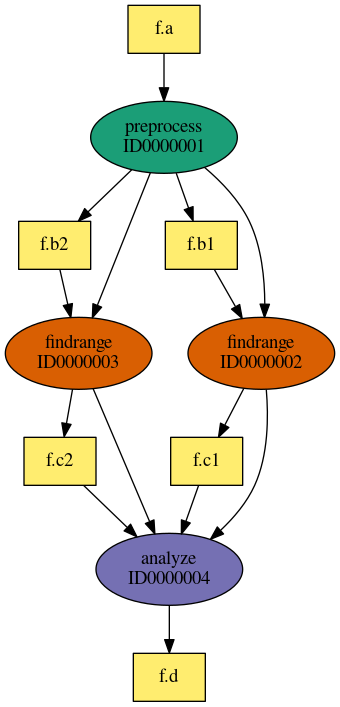

In [10]:
with open(dot_file, 'r') as file:
    graph_string = file.read()
# print(graph_string)
G = nx.drawing.nx_agraph.to_agraph(nx.nx_agraph.from_agraph(pgv.AGraph(graph_string)))
print(G)
pprint.pprint(G)
G.layout('dot')
G.draw('image.png')
Image(filename='image.png') 

In [11]:
for node in G.nodes():
#    print(dir(node.attr.iteritems()))
    print(node.attr['label'], ":")
    for attribute in node.attr.iteritems():
        pprint.pprint(attribute)

preprocess\nID0000001 :
('color', '#000000')
('fillcolor', '#1b9e77')
('height', '0.74639')
('label', 'preprocess\\nID0000001')
('pos', '119,423')
('shape', 'ellipse')
('width', '1.5299')
f.b2 :
('color', '#000000')
('height', '0.5')
('label', 'f.b2')
('pos', '37,342')
('shape', 'rect')
('width', '0.75')
f.b1 :
('color', '#000000')
('height', '0.5')
('label', 'f.b1')
('pos', '147,342')
('shape', 'rect')
('width', '0.75')
findrange\nID0000003 :
('color', '#000000')
('fillcolor', '#d95f02')
('height', '0.74639')
('label', 'findrange\\nID0000003')
('pos', '55,261')
('shape', 'ellipse')
('width', '1.5299')
findrange\nID0000002 :
('color', '#000000')
('fillcolor', '#d95f02')
('height', '0.74639')
('label', 'findrange\\nID0000002')
('pos', '192,261')
('shape', 'ellipse')
('width', '1.5299')
f.c2 :
('color', '#000000')
('height', '0.5')
('label', 'f.c2')
('pos', '41,180')
('shape', 'rect')
('width', '0.75')
analyze\nID0000004 :
('color', '#000000')
('fillcolor', '#7570b3')
('height', '0.74639

In [12]:
dotFormat = """
digraph G{
edge [dir=forward]
node [shape=plaintext]
0 [label="0 (None)"]
0 -> 7 [label="root"]
1 [label="1 (The)"]
4 [label="4 (great Indian Circus)"]
4 -> 4 [label="compound"]
4 -> 1 [label="det"]
4 -> 4 [label="amod"]
5 [label="5 (is)"]
6 [label="6 (in)"]
7 [label="7 (Mumbai)"]
7 -> 6 [label="case"]
7 -> 5 [label="cop"]
7 -> 4 [label="nsubj"]
}
"""

In [13]:
G = nx.drawing.nx_agraph.to_agraph(nx.nx_agraph.from_agraph(pgv.AGraph(dotFormat)))

In [14]:
pprint.pprint(G)

<AGraph b'G' <Swig Object of type 'Agraph_t *' at 0x7fdfbf37b9c0>>


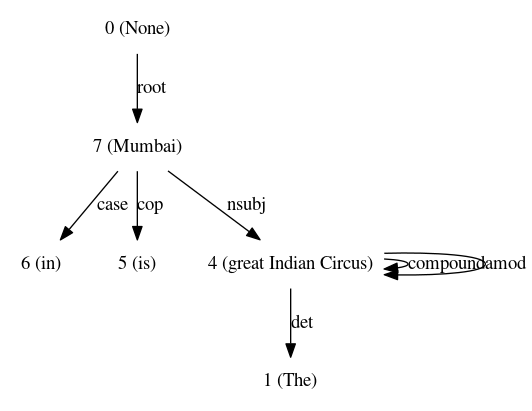

In [15]:
G.layout('dot')
G.draw('image.png')
Image(filename='image.png') 